In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 0. Загрузка данных

In [2]:
!wget 'https://docs.google.com/uc?id=1WP1vBhKIvwPX_kY3qrKMGqdWrCoh2Iv2' -O Mall_Customers.csv

--2023-11-06 13:01:17--  https://docs.google.com/uc?id=1WP1vBhKIvwPX_kY3qrKMGqdWrCoh2Iv2
Resolving docs.google.com (docs.google.com)... 142.251.31.101, 142.251.31.113, 142.251.31.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.31.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kpt9pj1ca9pds66go8ev0bg3talgcgi3/1699275675000/02611596255248067438/*/1WP1vBhKIvwPX_kY3qrKMGqdWrCoh2Iv2?uuid=de03f474-e2fa-4225-8494-999c90c72212 [following]
--2023-11-06 13:01:18--  https://doc-0c-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kpt9pj1ca9pds66go8ev0bg3talgcgi3/1699275675000/02611596255248067438/*/1WP1vBhKIvwPX_kY3qrKMGqdWrCoh2Iv2?uuid=de03f474-e2fa-4225-8494-999c90c72212
Resolving doc-0c-84-docs.googleusercontent.com (doc-0c-84-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connecting to doc-0c-84-

In [3]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 1. Первичный и визуальный анализ данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


В датасете 200 наблюдений, 5 признаков: 4 вещественных и 1 категориальный. Пропусков нет.

In [5]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


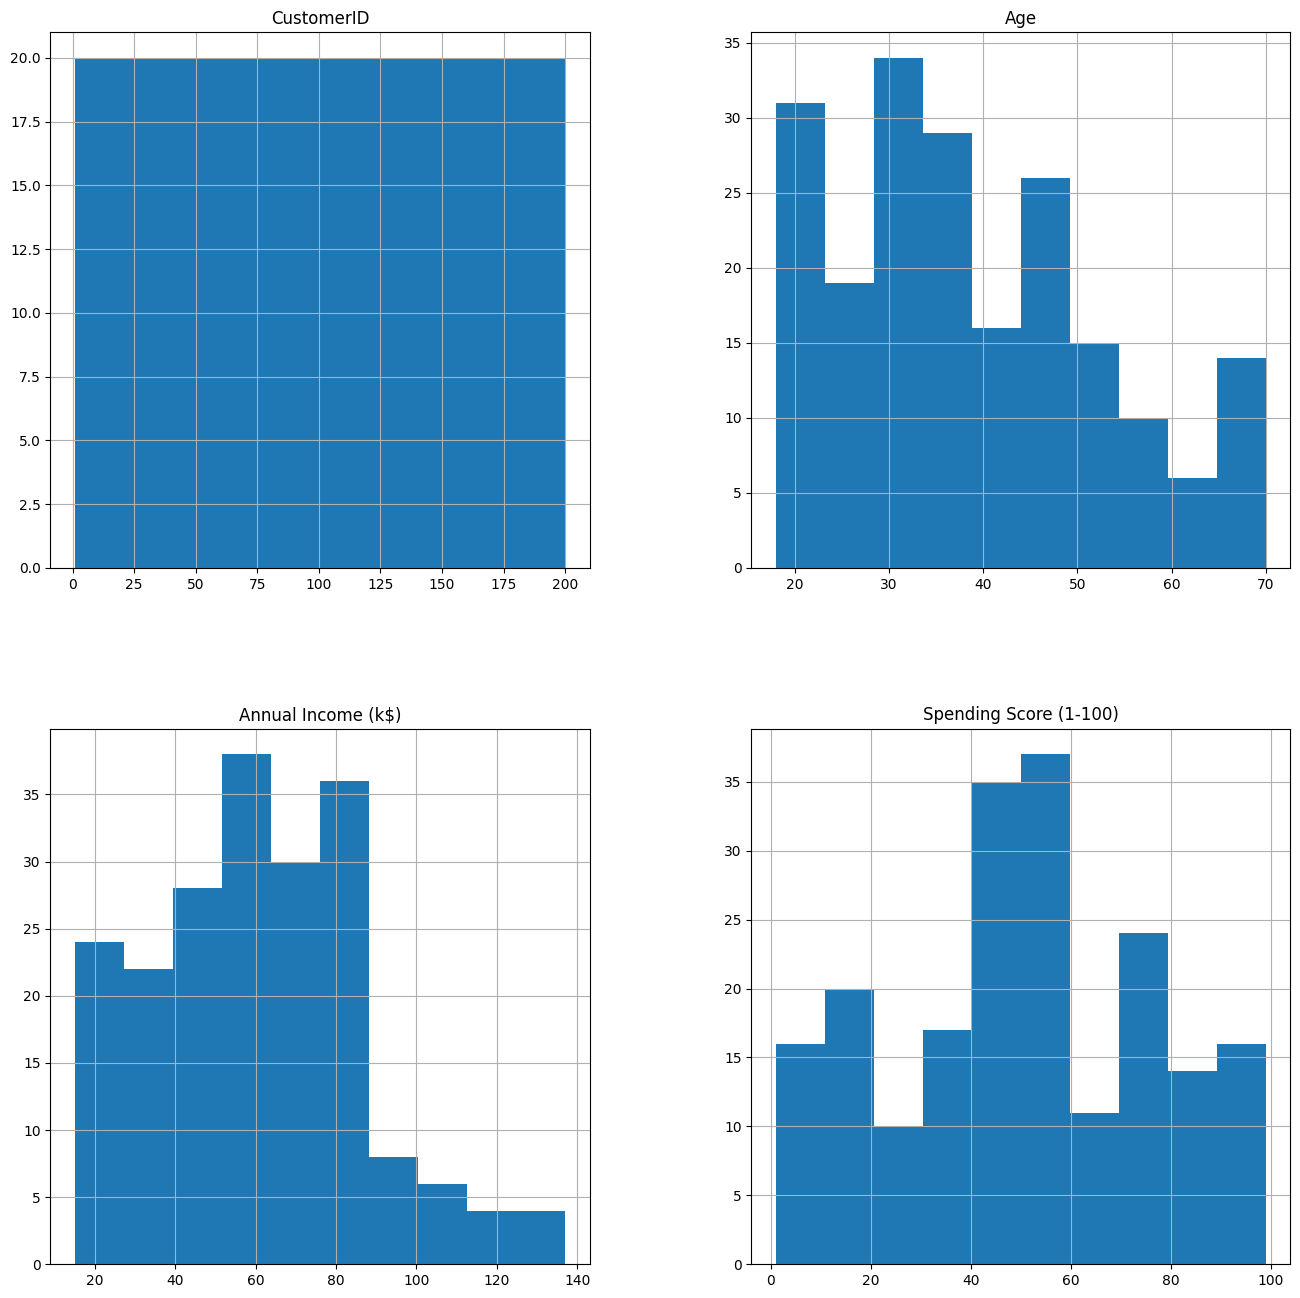

In [6]:
# отделение вещественных признаков
num_features = list(df.select_dtypes(['int64']).columns)

df.hist(num_features, figsize=(16, 16));

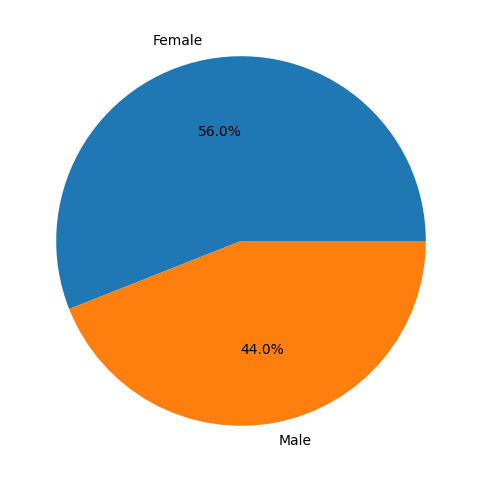

In [7]:
df_to_pie = df['Gender'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(df_to_pie.values, labels=df_to_pie.index, autopct='%.1f%%');

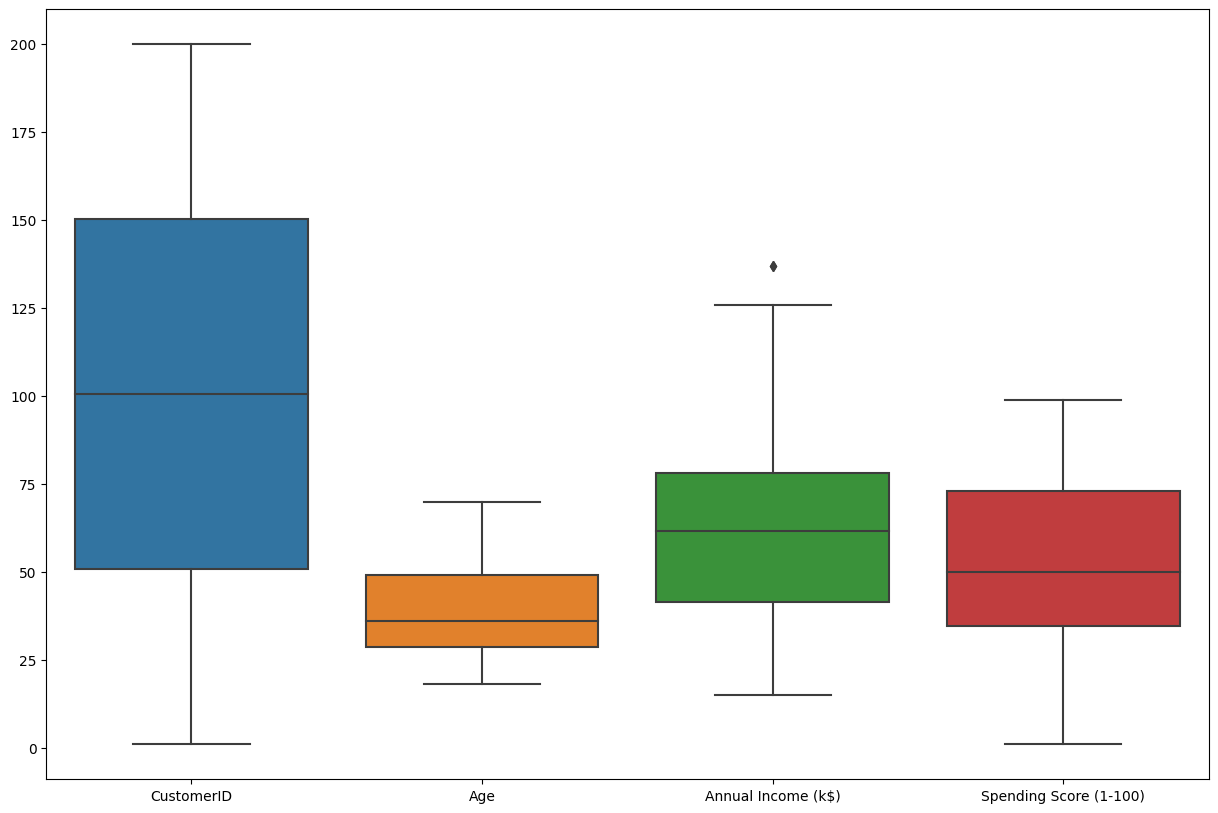

In [8]:
plt.figure(figsize=(15, 10))
sns.boxplot(df[num_features]);

Судя по диаграмме размаха, выбросы имеются только у признака `Annual Income`.

Посмотрим на плотность распределения вероятности признака `Spending Score (1-100)` - оценка расходов

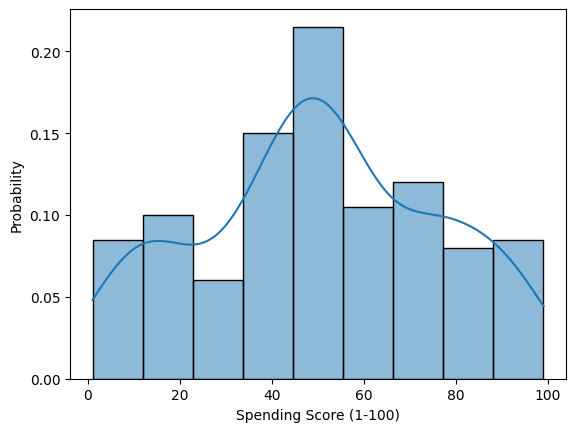

In [9]:
sns.histplot(df['Spending Score (1-100)'], kde=True, stat='probability');

## 2. Удаление бесполезных признаков

Признак `CustomerID` выступает в роли счетчика и не несёт смысловой нагрузки.

In [10]:
num_features.remove('CustomerID')

## 3. Предобработка данных

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

num_pipe = make_pipeline(
    MinMaxScaler()
)

cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore")          # игнорирование неопознанных данных на тесте или в рабочих данных
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, ['Gender']),
    ]
)


In [12]:
df_transform = preprocessor.fit_transform(df)

In [13]:
# имена колонок
col_names = num_features.copy()
col_names.append('Gender_Female')
col_names.append('Gender_Male')

In [14]:
df_transform = pd.DataFrame(df_transform, columns=col_names)
df_transform

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,0.019231,0.000000,0.387755,0.0,1.0
1,0.057692,0.000000,0.816327,0.0,1.0
2,0.038462,0.008197,0.051020,1.0,0.0
3,0.096154,0.008197,0.775510,1.0,0.0
4,0.250000,0.016393,0.397959,1.0,0.0
...,...,...,...,...,...
195,0.326923,0.860656,0.795918,1.0,0.0
196,0.519231,0.909836,0.275510,1.0,0.0
197,0.269231,0.909836,0.744898,0.0,1.0
198,0.269231,1.000000,0.173469,0.0,1.0


## 4. Обучение модели понижения размерности для визуализации данных в 2D пространстве

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def reduce_dims(df, dims=2, method='pca', perplexity=30):

    assert method in ['pca', 'tsne'], 'Неверно указан метод'

    if method == 'pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')

    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames)

In [16]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')
    plt.show()

In [17]:
dim_reducer2d, components_2d = reduce_dims(df_transform, dims=2, method='tsne')
components_2d.head(2)

,component_1,component_2
0,27.065092,-0.272301
1,29.196939,0.417369


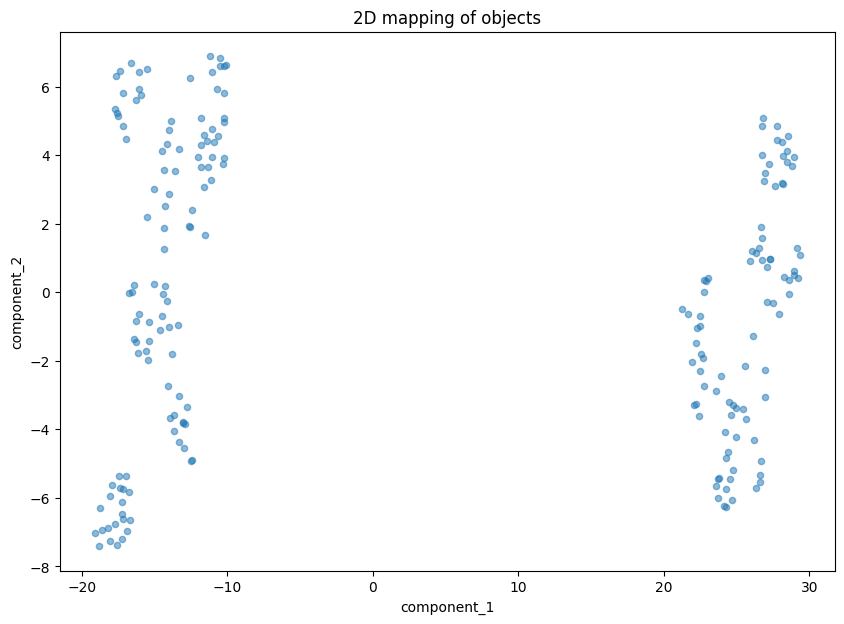

In [18]:
display_components_in_2D_space(components_2d)

## 5. Обучение не менее 2 моделей кластеризации

### 5.1 KMeans

In [20]:
def display_clusters_distribution(unique, counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

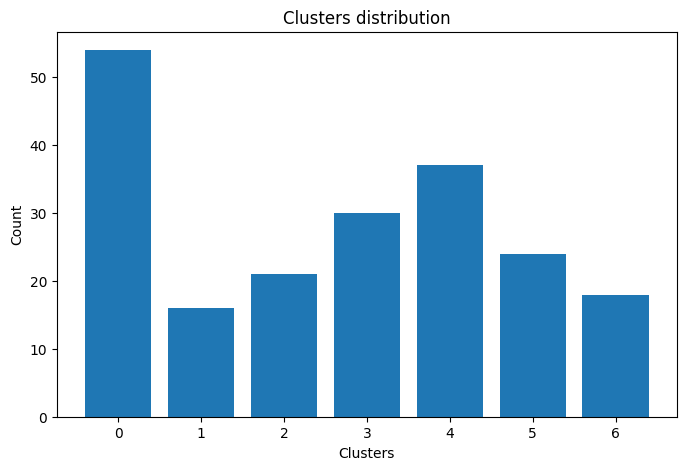

In [63]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
labels_clast_km = kmeans.fit_predict(df_transform)

unique, counts = np.unique(pd.Series(labels_clast_km), return_counts=True)
display_clusters_distribution(unique, counts)

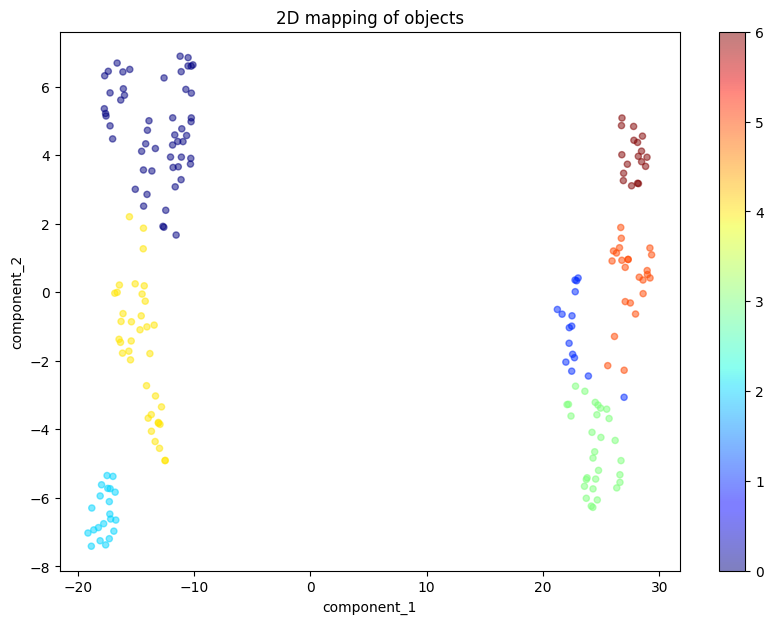

In [64]:
display_components_in_2D_space(components_2d, labels_clast_km)

### 5.2 DBSCAN

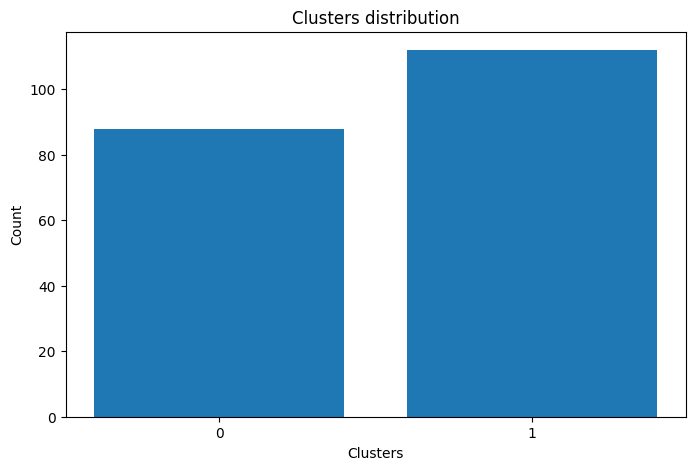

In [61]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=.5, min_samples=5)
labels_clast_db = dbscan.fit_predict(df_transform)


unique, counts = np.unique(pd.Series(labels_clast_db), return_counts=True)
display_clusters_distribution(unique, counts)

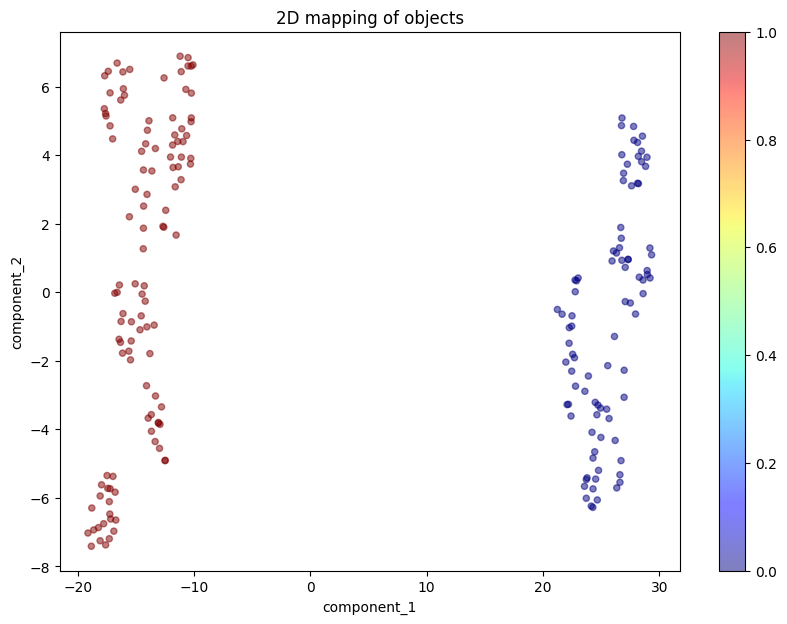

In [62]:
display_components_in_2D_space(components_2d, labels_clast_db)

## 6. Найти оптимальное количество кластеров

In [46]:
from scipy.spatial.distance import cdist

In [49]:
def apply_elbow_method_kmeans(X):
    """Визуализация метода 'локтя' для модели кластеризации KMeans"""

    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

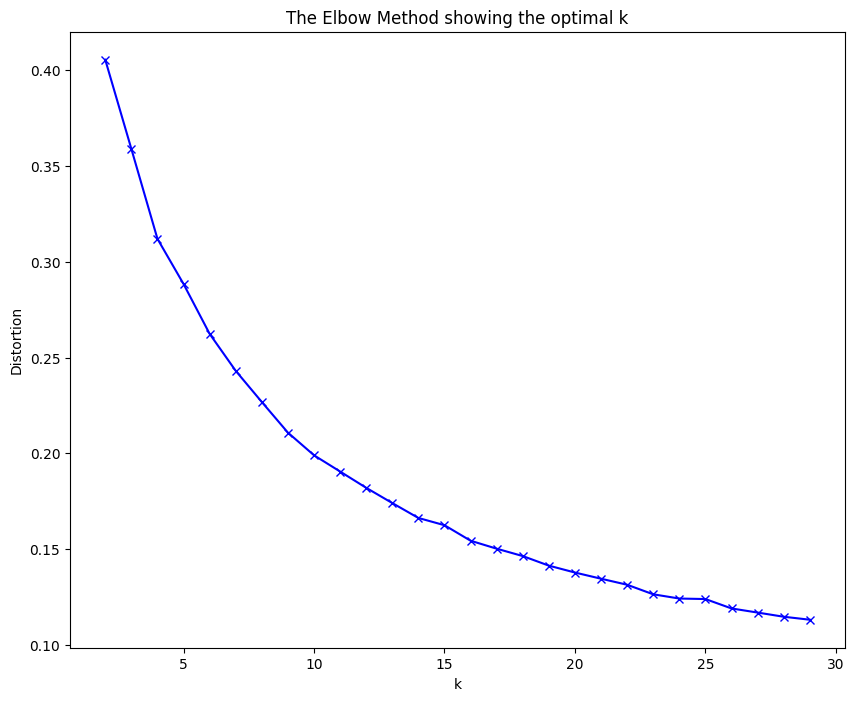

CPU times: user 4.09 s, sys: 109 ms, total: 4.2 s
Wall time: 2.84 s


In [50]:
%%time
apply_elbow_method_kmeans(df_transform)

## 7. Визуализация полученных кластеров

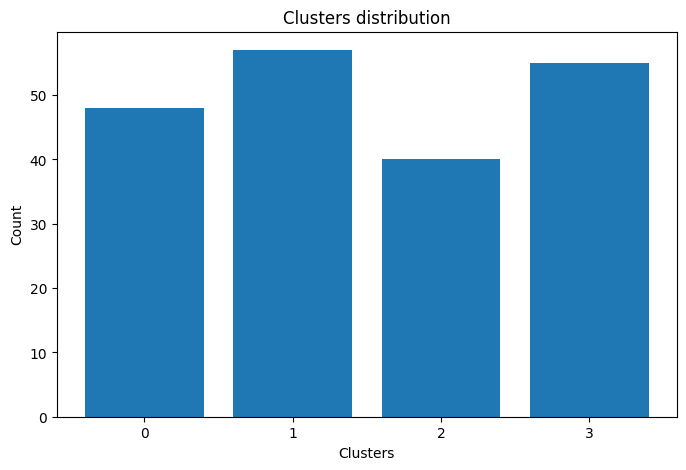

In [65]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels_clast_km = kmeans.fit_predict(df_transform)

unique, counts = np.unique(pd.Series(labels_clast_km), return_counts=True)
display_clusters_distribution(unique, counts)

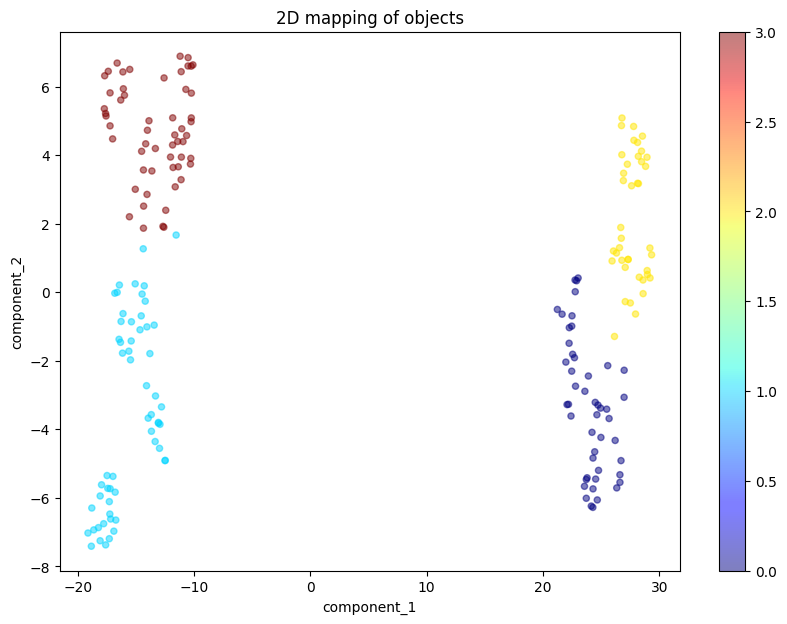

In [66]:
display_components_in_2D_space(components_2d, labels_clast_km)

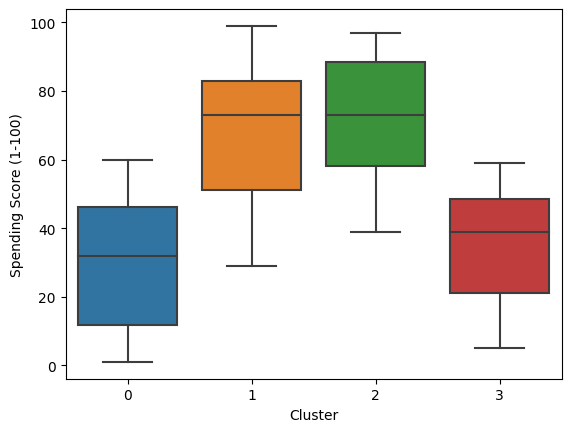

In [79]:
sns.boxplot(x=df["Cluster"], y=df["Spending Score (1-100)"]);

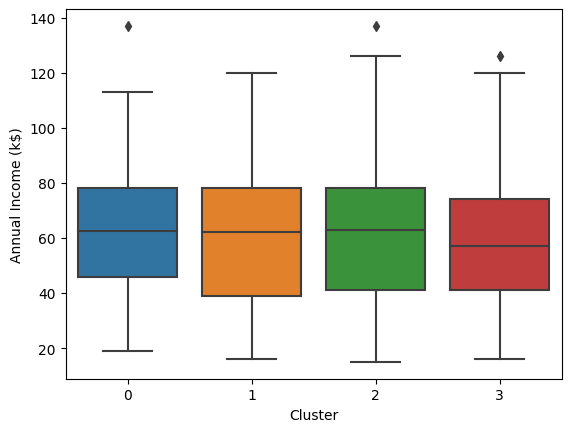

In [ ]:
sns.boxplot(x=df["Cluster"], y=df["Annual Income (k$)"]);

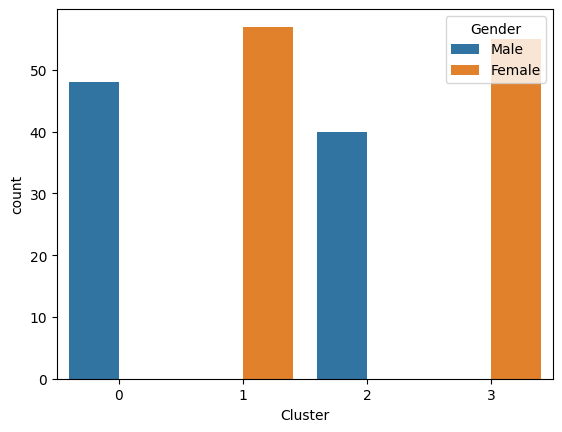

In [80]:
sns.countplot(x=df["Cluster"], hue=df['Gender']);

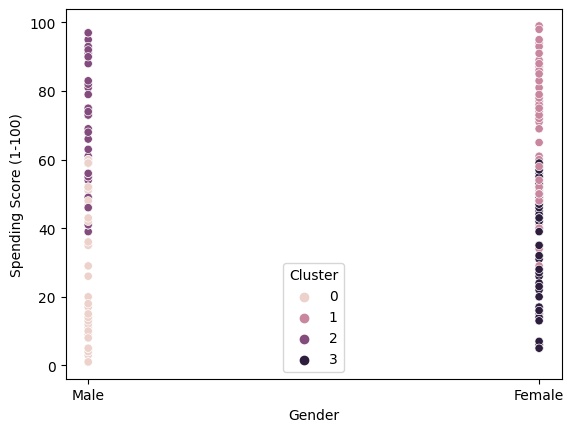

In [85]:
sns.scatterplot(data=df, x=df["Gender"], y=df["Spending Score (1-100)"], hue=df["Cluster"]);

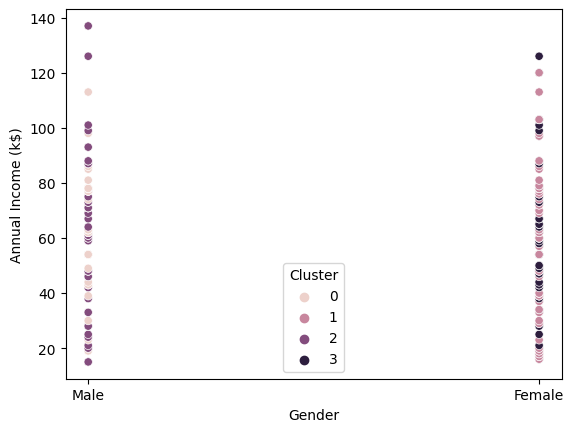

In [92]:
sns.boxplot(data=df, x=df["Gender"], y=df["Annual Income (k$)"], hue=df["Cluster"]);

## 8. Выводы

1. Оптимальное количество кластеров для модели кластеризации KMeans ~ 4;
2. Эмпирическим путем выявлено, что с использованием модели DBSCAN обнаруживается только 2 кластера в данных;
3. Распределение наблюдений по кластерам KMeans:

  3.1 В кластер 0 попали только мужчины, имеющие меньший скор расходов,

  3.2 в кластер 1 - только женщины, имеющие больший скор расходов,

  3.3 в кластер 2 - только мужчины, имеющие больший скор расходов,

  3.4 в кластер 3 - только женщины, имеющие меньший скор расходов.

4. Модель KMeans распределила наблюдения по кластерам по критерию равенства среднегодового дохода